# Assignment 1: Mobile Price Classification
# Cade Boiney and Benjamin Zhao

## Install Dependencies

In [16]:
%pip install torch torchvision torchaudio --quiet
%pip install scikit-learn --quiet
%pip install matplotlib seaborn pandas numpy --quiet


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Set Seed

In [18]:
import numpy as np
import torch
import random

# Set random seeds for reproducibility
seed = 2025
random.seed(seed)        
np.random.seed(seed)     
torch.manual_seed(seed)  
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed) 

## Load and Explore Dataset

In [19]:
def load_data(path):
    df = pd.read_csv(path)
    print(f'Dataset shape: {df.shape}')
    print(f'Features: {list(df.columns)}')
    return df

train_df = load_data("train.csv")
print(train_df.head())
print(train_df.info())
print(train_df.describe())

# Check missing values
if train_df.isnull().values.any():
    print("Missing values detected!")
else:
    print("No missing values.")

Dataset shape: (2000, 21)
Features: ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi', 'price_range']
   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        1

## Exploratory Data Analysis

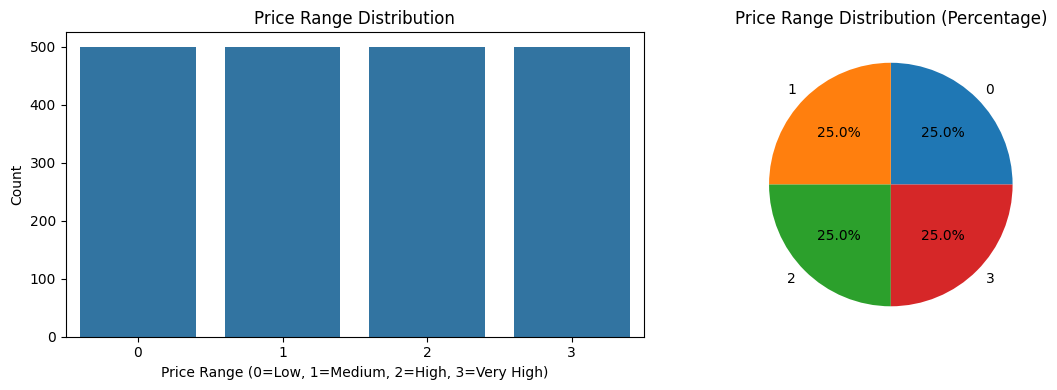

Target distribution:
price_range
0    500
1    500
2    500
3    500
Name: count, dtype: int64


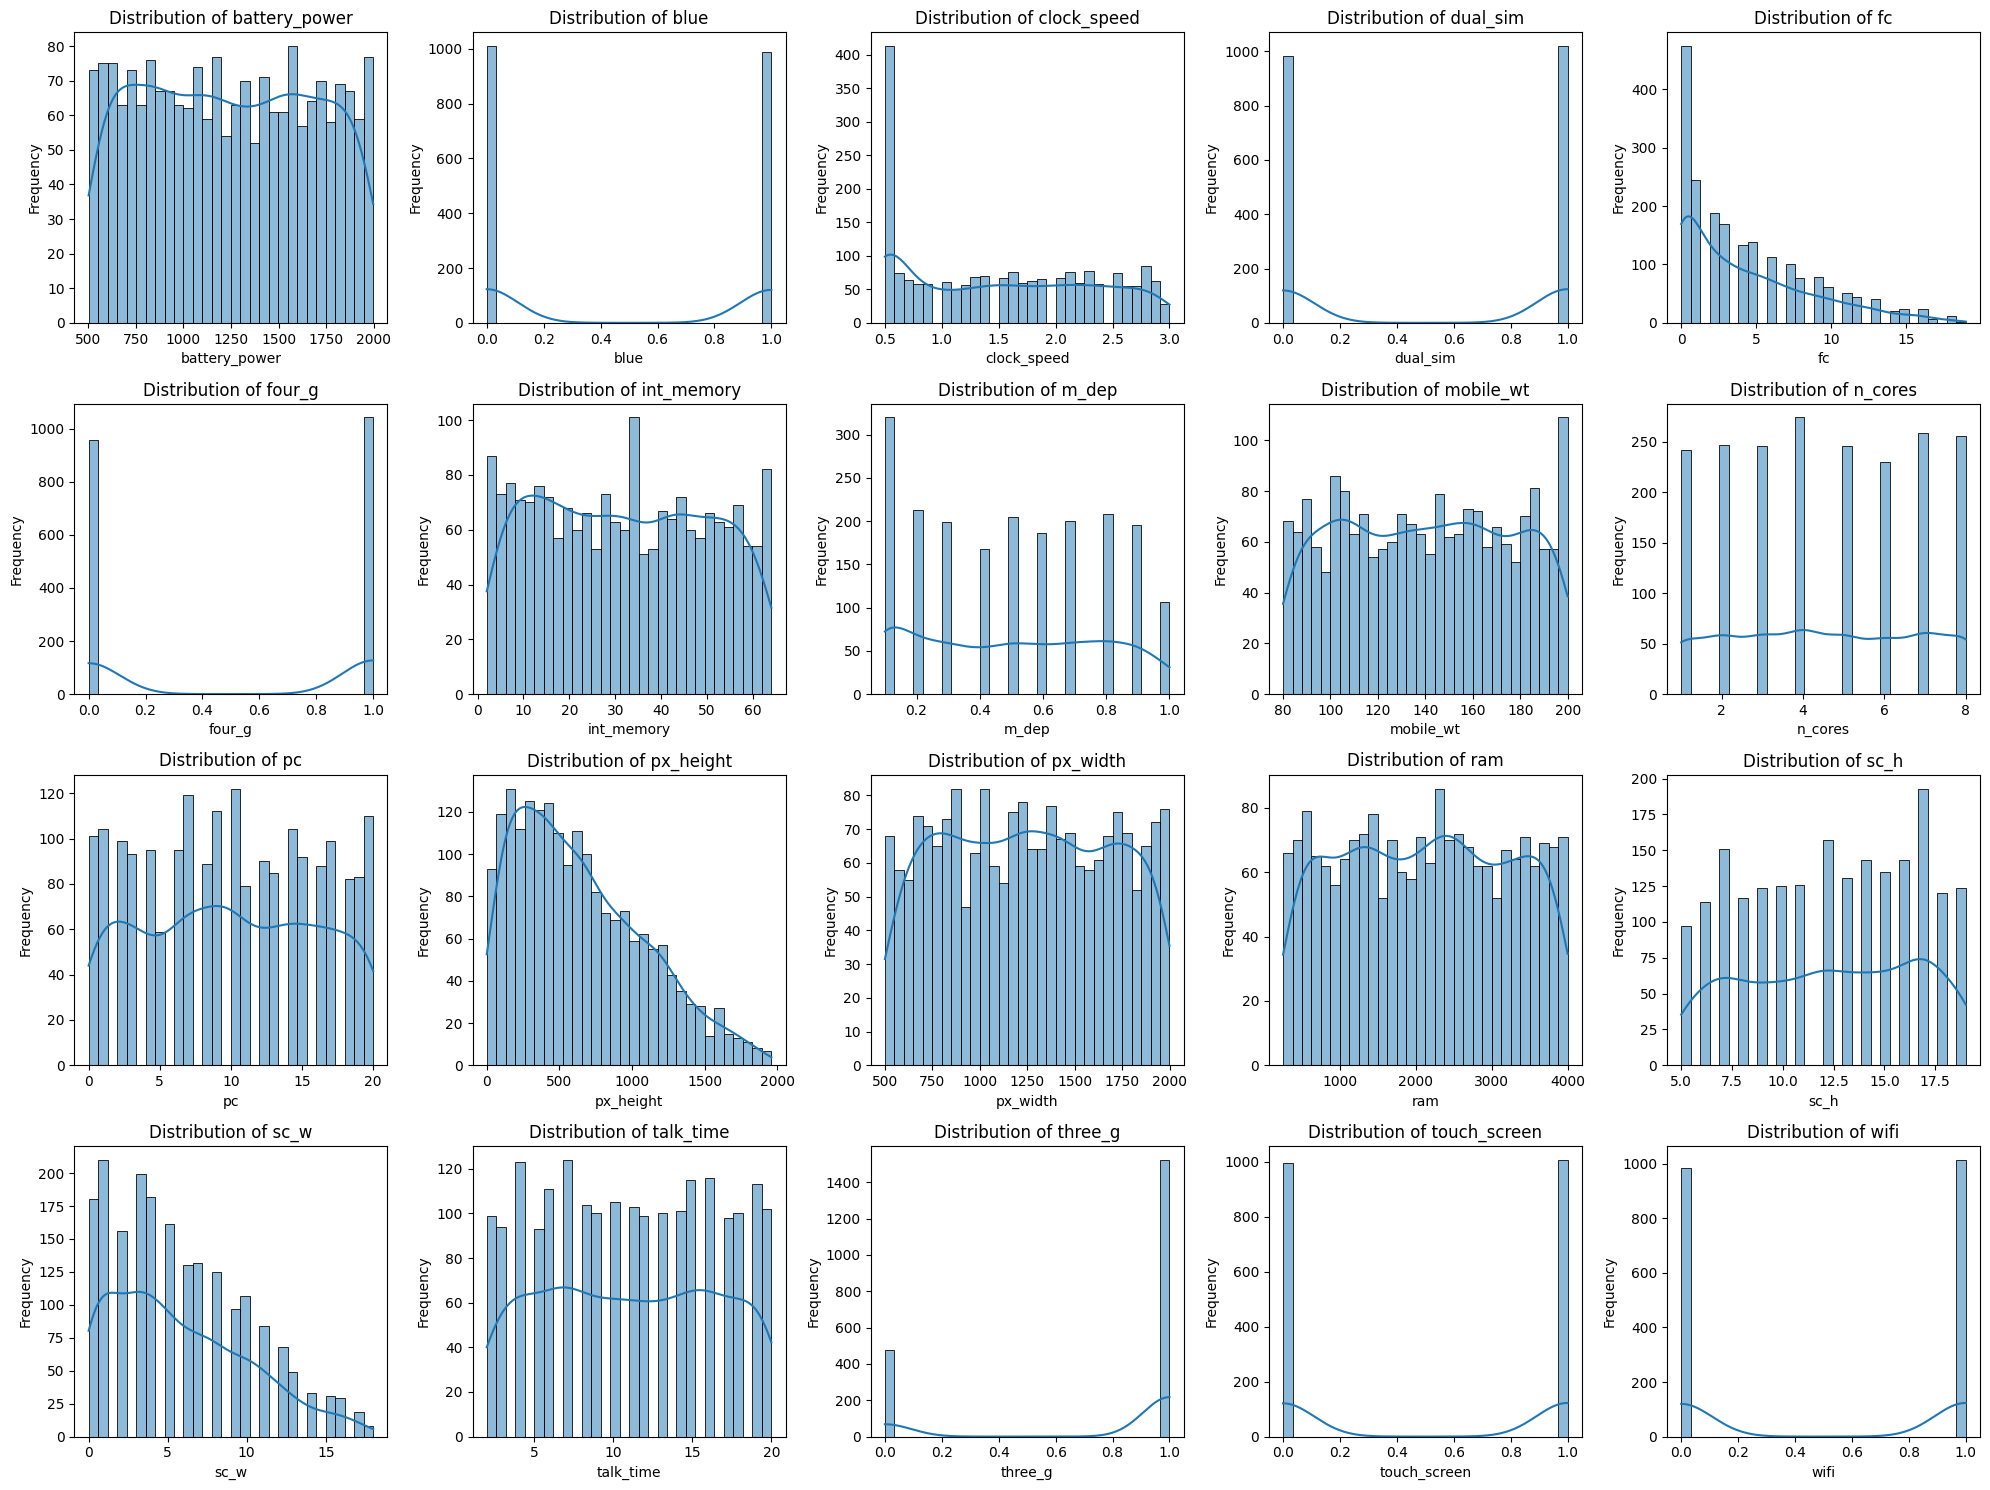

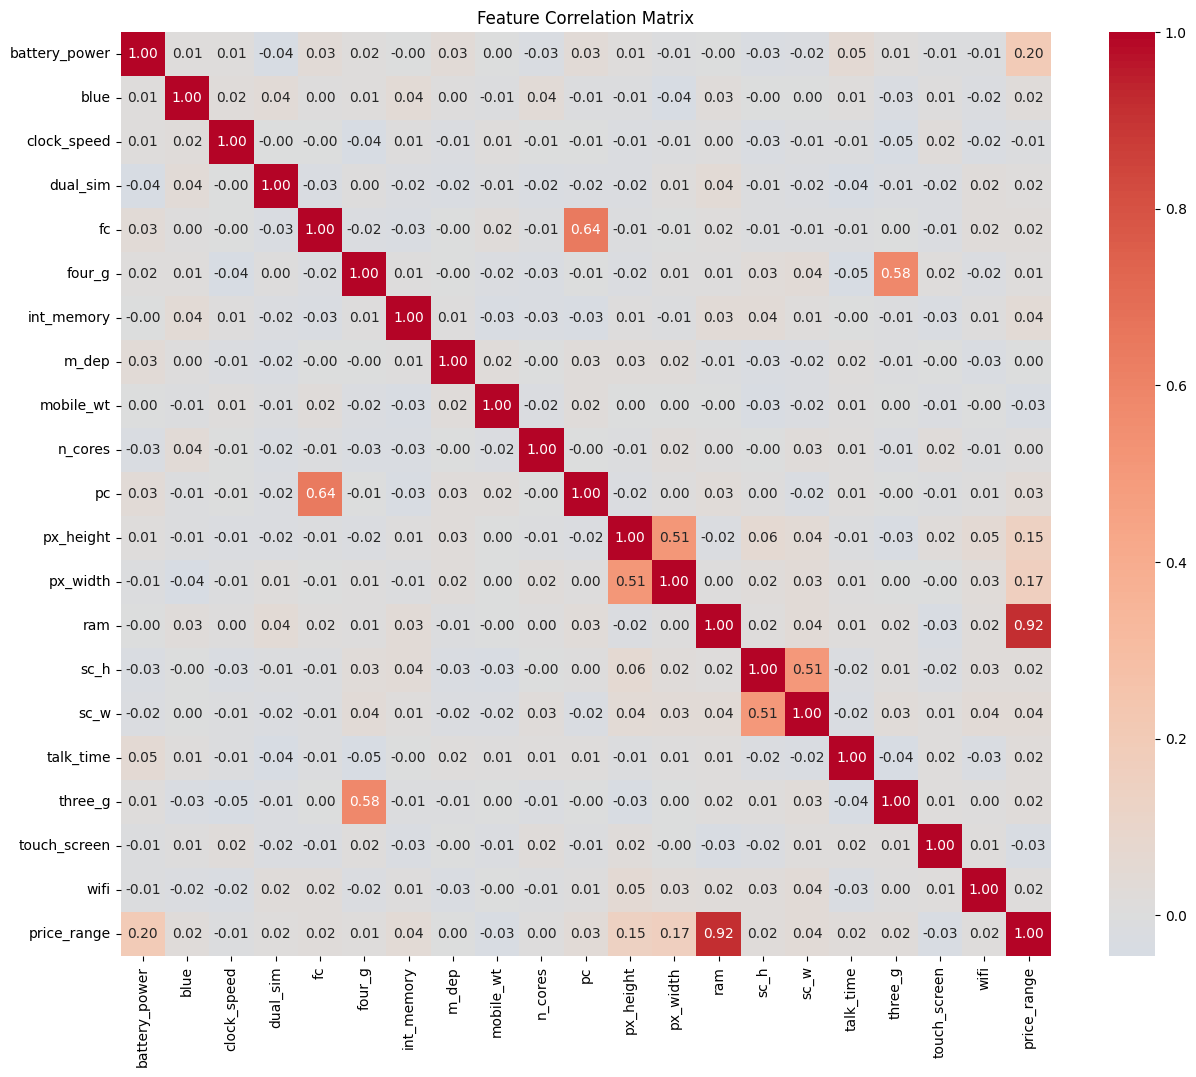


Feature correlation with price_range:
price_range      1.000000
ram              0.917046
battery_power    0.200723
px_width         0.165818
px_height        0.148858
int_memory       0.044435
sc_w             0.038711
pc               0.033599
three_g          0.023611
sc_h             0.022986
fc               0.021998
talk_time        0.021859
blue             0.020573
wifi             0.018785
dual_sim         0.017444
four_g           0.014772
n_cores          0.004399
m_dep            0.000853
clock_speed     -0.006606
mobile_wt       -0.030302
touch_screen    -0.030411
Name: price_range, dtype: float64


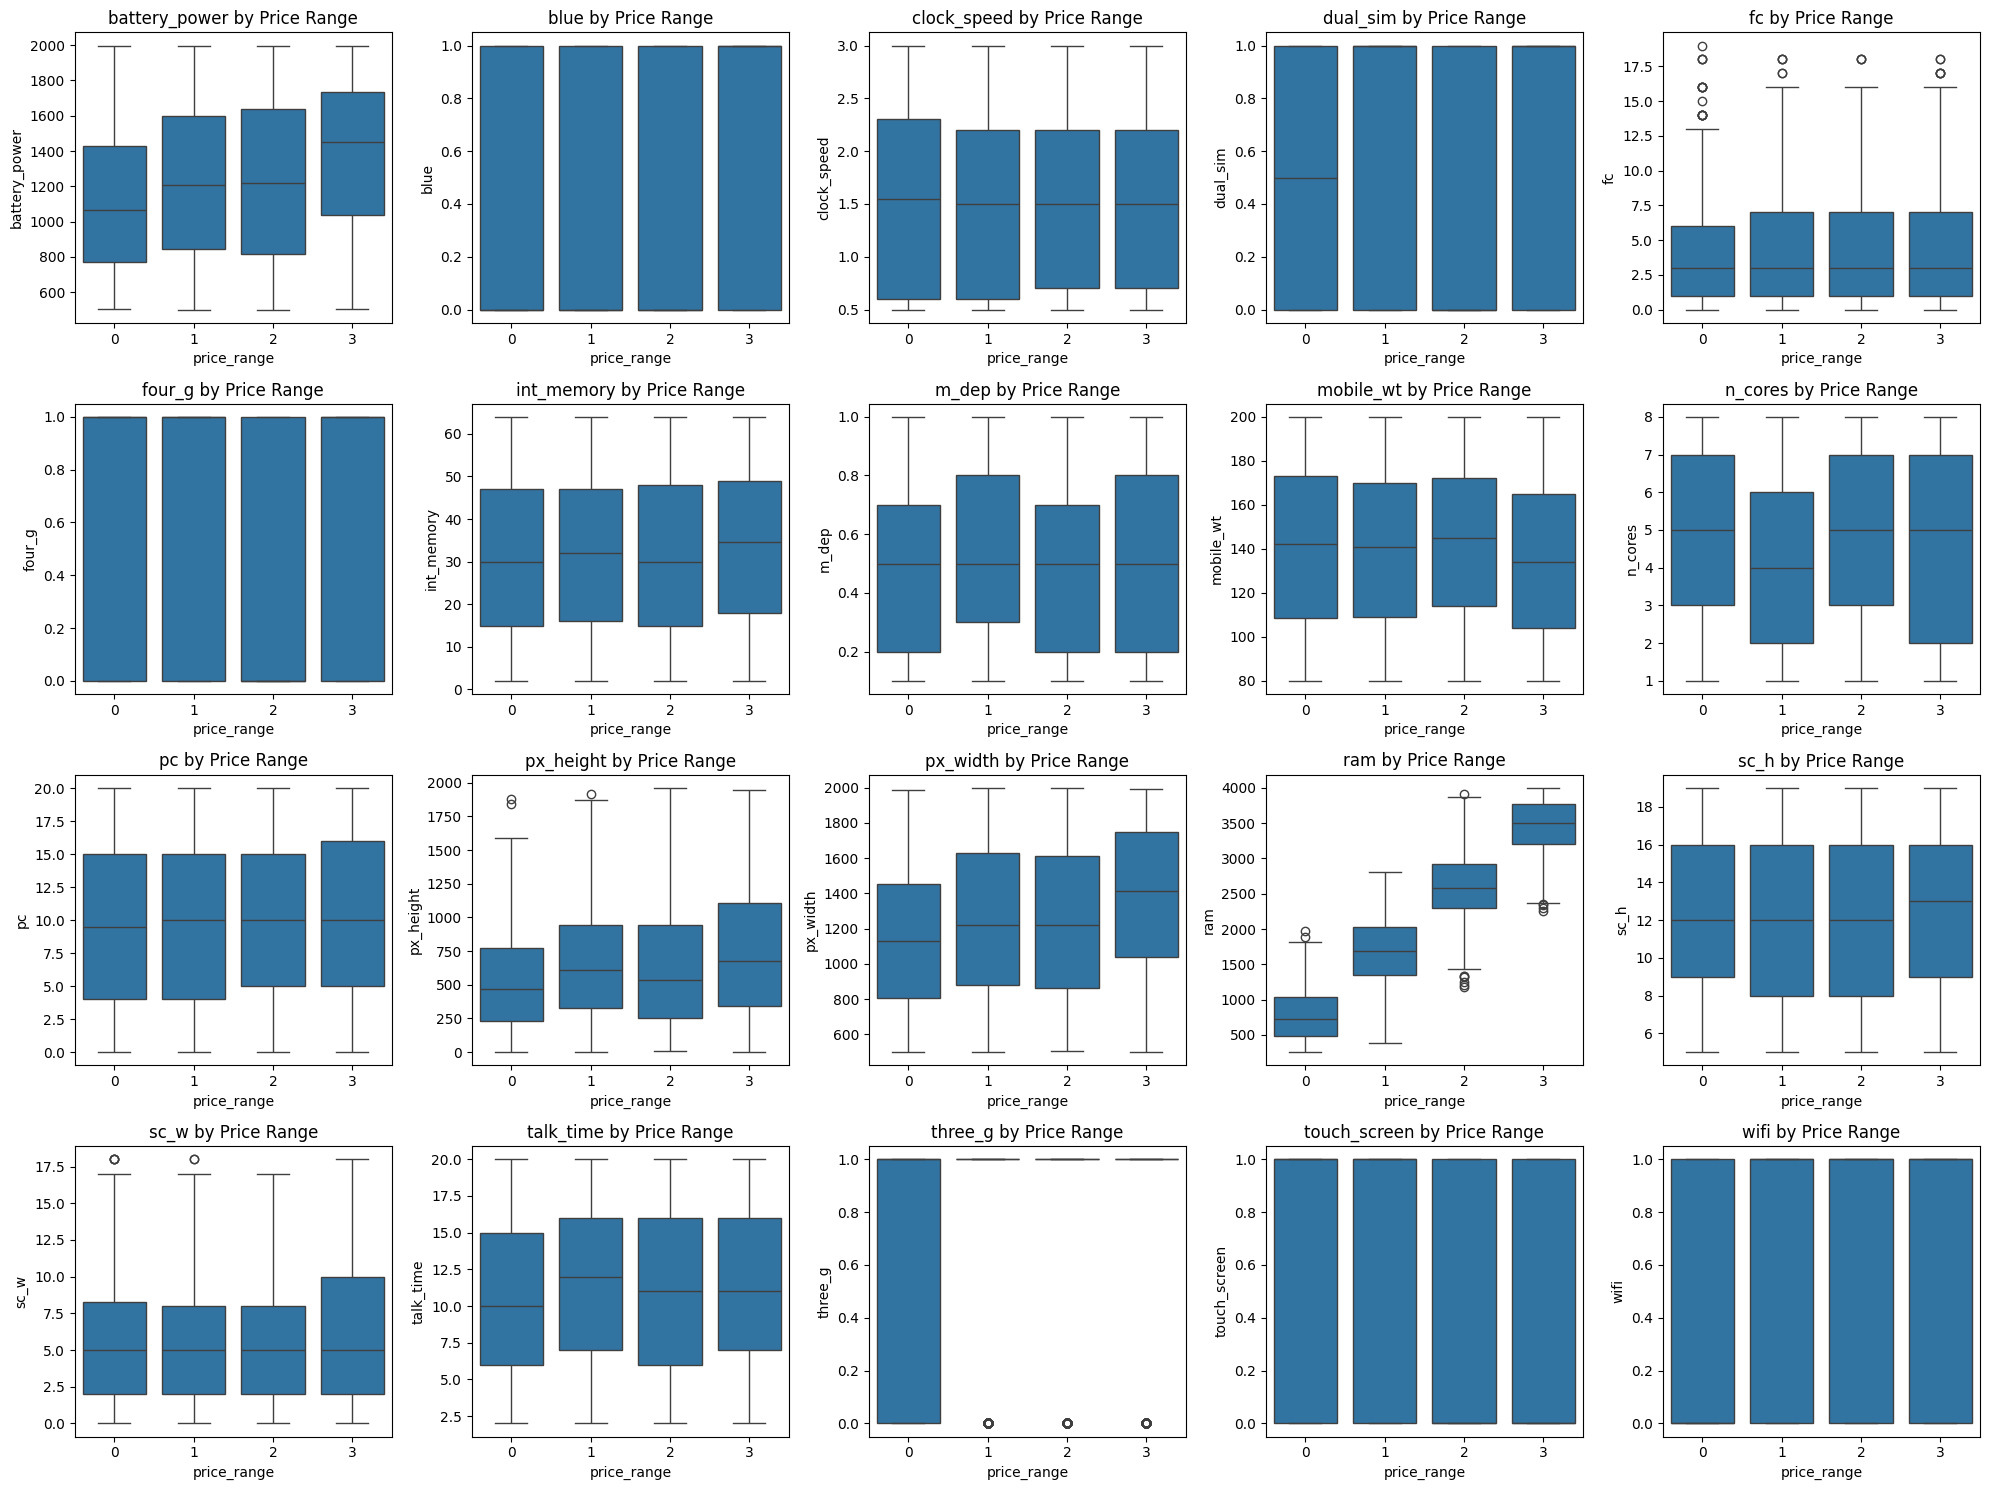

In [20]:
# Target variable distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.countplot(x='price_range', data=train_df)
plt.title('Price Range Distribution')
plt.xlabel('Price Range (0=Low, 1=Medium, 2=High, 3=Very High)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
train_df['price_range'].value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%')
plt.title('Price Range Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.show()

print("Target distribution:")
print(train_df['price_range'].value_counts().sort_index())

# %%
# Feature distributions
plt.figure(figsize=(20, 15))
features = train_df.drop('price_range', axis=1).columns

for i, feature in enumerate(features):
    plt.subplot(4, 5, i+1)
    sns.histplot(train_df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# %%
# Correlation analysis
plt.figure(figsize=(15, 12))
correlation_matrix = train_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

# Feature correlation with target
target_corr = train_df.corr()['price_range'].sort_values(ascending=False)
print("\nFeature correlation with price_range:")
print(target_corr)

# %%
# Box plots for features by price range
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features):
    plt.subplot(4, 5, i+1)
    sns.boxplot(x='price_range', y=feature, data=train_df)
    plt.title(f'{feature} by Price Range')

plt.tight_layout()
plt.show()

## Data Preprocessing

In [21]:
X = train_df.drop(columns=['price_range'])
y = train_df['price_range']
num_classes = len(y.unique())

# First split: train+val vs test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=1, stratify=y
)

# Second split: train vs val
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.15, random_state=1, stratify=y_trainval
)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")


# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


Train size: 1445
Validation size: 255
Test size: 300


## PyTorch Dataset

In [22]:
class MobilePriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MobilePriceDataset(X_train_scaled, y_train)
val_dataset   = MobilePriceDataset(X_val_scaled, y_val)
test_dataset  = MobilePriceDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)


## Optimal MLP Model (32→16→4)

In [23]:
class OptimalMLPClassifier(nn.Module):
    def __init__(self, input_features, num_classes=4):
        super().__init__()
        self.fc1 = nn.Linear(input_features, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, num_classes)
        self.dropout = nn.Dropout(0.5)
        self._initialize_weights()
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = OptimalMLPClassifier(input_features=X_train_scaled.shape[1], num_classes=num_classes).to(device)

Using device: cpu


## Training Loop with Early Stopping + LR Scheduler

In [24]:
def train_model(model, train_loader, val_loader, epochs=1200, patience=100):
    """
    Train the optimal MLP (32→16) with:
    - Early stopping based on validation accuracy
    - CosineAnnealingLR scheduler
    - Saves best model automatically
    """
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    best_val_acc = 0.0
    patience_counter = 0

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Scheduler step
        scheduler.step()

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

        # Progress print
        if (epoch + 1) % 50 == 0 or epoch < 5:
            print(f'Epoch {epoch+1}/{epochs} - '
                  f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
                  f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, '
                  f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

    print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.4f}")
    return train_losses, val_losses, train_accs, val_accs, best_val_acc

# Train Model

In [ ]:
train_losses, val_losses, train_accs, val_accs, best_val_acc = train_model(
    model, train_loader, val_loader, epochs=1200, patience=200
)

Epoch 1/1200 - Train Loss: 1.8809, Val Loss: 1.4583, Train Acc: 0.2457, Val Acc: 0.2588, LR: 0.001000
Epoch 2/1200 - Train Loss: 1.7456, Val Loss: 1.4335, Train Acc: 0.2581, Val Acc: 0.2784, LR: 0.001000
Epoch 3/1200 - Train Loss: 1.7436, Val Loss: 1.4128, Train Acc: 0.2498, Val Acc: 0.3098, LR: 0.001000
Epoch 4/1200 - Train Loss: 1.7023, Val Loss: 1.3946, Train Acc: 0.2637, Val Acc: 0.3176, LR: 0.001000
Epoch 5/1200 - Train Loss: 1.6478, Val Loss: 1.3799, Train Acc: 0.2401, Val Acc: 0.3333, LR: 0.001000
Epoch 50/1200 - Train Loss: 1.0079, Val Loss: 0.8417, Train Acc: 0.5114, Val Acc: 0.6392, LR: 0.000996
Epoch 100/1200 - Train Loss: 0.6948, Val Loss: 0.5346, Train Acc: 0.6858, Val Acc: 0.8118, LR: 0.000985
Epoch 150/1200 - Train Loss: 0.5154, Val Loss: 0.3601, Train Acc: 0.7834, Val Acc: 0.9020, LR: 0.000966
Epoch 200/1200 - Train Loss: 0.4316, Val Loss: 0.2710, Train Acc: 0.8263, Val Acc: 0.9412, LR: 0.000940
Epoch 250/1200 - Train Loss: 0.3529, Val Loss: 0.1958, Train Acc: 0.8637, V

## Load Best Model & Evaluate

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
correct, total = 0, 0
all_predictions, all_targets = [], []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

final_accuracy = correct / total
print(f"Final Validation Accuracy: {final_accuracy:.4f}")

Final Validation Accuracy: 0.9765


## Plot Learning Curves

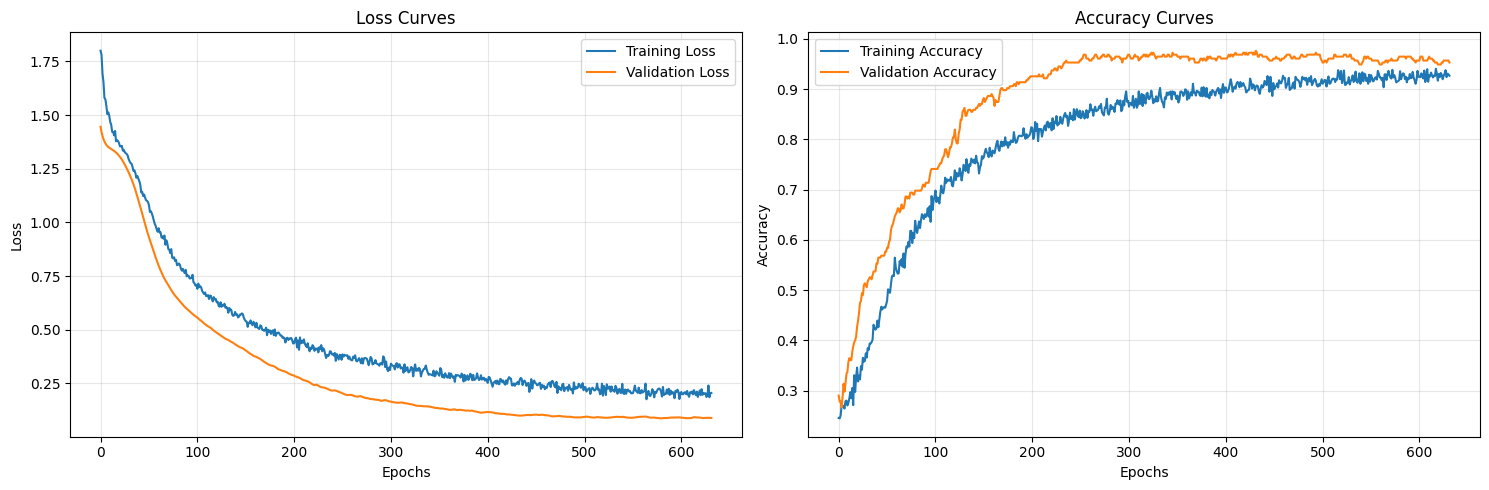

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Classification Report & Confusion Matrix

Classification Report:
                precision    recall  f1-score   support

      Low Cost       0.97      0.98      0.98        64
   Medium Cost       0.98      0.95      0.97        64
     High Cost       0.97      0.98      0.98        64
Very High Cost       0.98      0.98      0.98        63

      accuracy                           0.98       255
     macro avg       0.98      0.98      0.98       255
  weighted avg       0.98      0.98      0.98       255



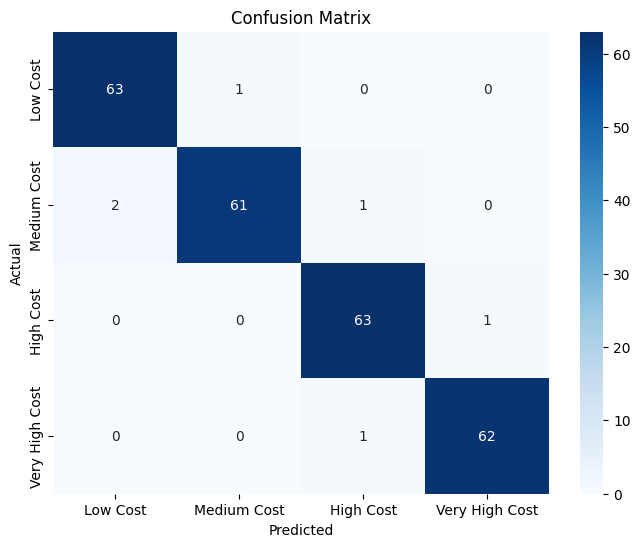

In [ ]:
target_names = ['Low Cost', 'Medium Cost', 'High Cost', 'Very High Cost']
report = classification_report(all_targets, all_predictions, target_names=target_names)
print("Classification Report:")
print(report)

conf_matrix = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Predict Function

In [14]:
def predict(model, data_loader, device, target_names=None):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_preds)
    report = classification_report(all_targets, all_preds, target_names=target_names, digits=4)
    conf_matrix = confusion_matrix(all_targets, all_preds)

    if target_names is not None:
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    return accuracy, report, conf_matrix

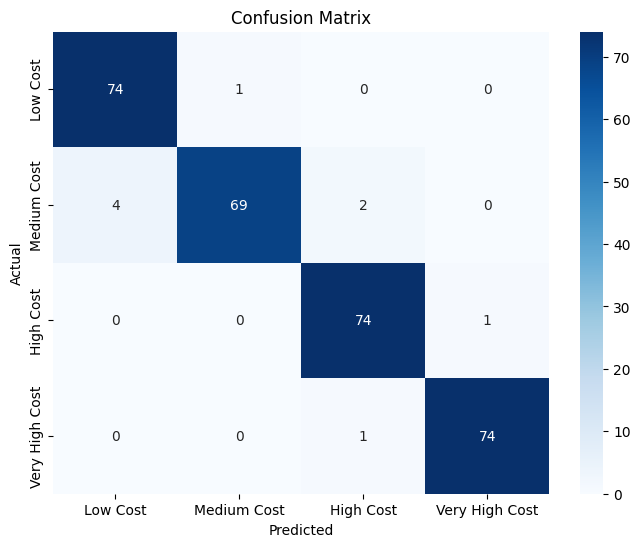

Final Test Accuracy: 0.9700
Final Test Classification Report:
                precision    recall  f1-score   support

      Low Cost     0.9487    0.9867    0.9673        75
   Medium Cost     0.9857    0.9200    0.9517        75
     High Cost     0.9610    0.9867    0.9737        75
Very High Cost     0.9867    0.9867    0.9867        75

      accuracy                         0.9700       300
     macro avg     0.9705    0.9700    0.9698       300
  weighted avg     0.9705    0.9700    0.9698       300



In [ ]:
# Load best model
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Final test evaluation
test_accuracy, test_report, test_conf_matrix = predict(
    model, test_loader, device, target_names=target_names
)

print(f"Final Test Accuracy: {test_accuracy:.4f}")
print("Final Test Classification Report:")
print(test_report)
